# Computer Vision 

## Assignment 2

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt
from operator import itemgetter

In [2]:
def Compute_GRAD(image):
    kernel_x = (1/8) * np.array([[1, 0, -1],
                                 [2, 0, -2],
                                 [1, 0, -1]])
    kernel_y = (1/8) * np.array([[1, 2, 1],
                                 [0, 0, 0],
                                 [-1, -2, -1]])
    grad_x = cv2.filter2D(image, -1, kernel_x)
    grad_y = cv2.filter2D(image, -1, kernel_y)
    return grad_x, grad_y

In [42]:
path = 'image_sets/yosemite/Yosemite1.jpg'
img = cv2.imread(path, 0)/255
real_img = cv2.imread(path)

In [43]:
path = 'image_sets/yosemite/Yosemite2rot.jpg'
img_second = cv2.imread(path, 0)/255
real_img_second = cv2.imread(path)

In [44]:
# path = 'image_sets/graf/img1.ppm'
# img = cv2.imread(path, 0)/255
# real_img = cv2.imread(path)

In [45]:
# path = 'image_sets/graf/img2.ppm'
# img_second = cv2.imread(path, 0)/255
# real_img_second = cv2.imread(path)

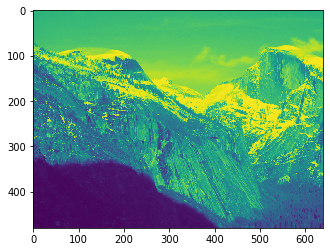

In [46]:
plt.imshow(img)

In [47]:
print(img.shape)

(480, 640)


### Feature Detection

In [48]:
def Compute_HARRIS_MAT(grad_x, grad_y):
    grad_x2 = grad_x**2
    grad_y2 = grad_y**2
    grad_x2 = cv2.GaussianBlur(grad_x2, (5, 5), 3, 3)
    grad_y = cv2.GaussianBlur(grad_y2, (5, 5), 3, 3)
    grad_xy = cv2.GaussianBlur(grad_x*grad_y , (5, 5), 3, 3)
    return grad_x2, grad_y2, grad_xy

def Create_H(grad_x2, grad_y2, grad_xy):
    upper_left = cv2.boxFilter(grad_x2, ksize=(5,5), ddepth= -1, normalize = False)
    upper_right = cv2.boxFilter(grad_xy, ksize=(5,5), ddepth= -1, normalize = False)
#     lower_left = cv2.boxFilter(grad_xy, ksize=(5,5), ddepth= -1, normalize = False)
    lower_right = cv2.boxFilter(grad_y2, ksize=(5,5), ddepth=-1,normalize = False)
    return upper_left ,lower_right, upper_right
    
def Corner_Response(grad_x2, grad_y2, grad_xy, alpha = 0.04):
    return ((grad_x2*grad_y2 - grad_xy*grad_xy) - alpha*(grad_x2+grad_y2))

def Threshold(array: np.ndarray, thresh: float):
    thresh_array = np.copy(array)
    thresh_array[array < thresh] = 0
    return thresh_array

def Non_Max_Supression(array: np.ndarray, kernel_size: int = 5):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    dilated = cv2.dilate(array, kernel, borderType=cv2.BORDER_CONSTANT, borderValue=[0, 0, 0])
    max_array = np.copy(array)
    max_array[max_array < dilated] = 0
    return max_array

In [68]:
def Computate_Coner_Strength(img):
    I_x, I_y = Compute_GRAD(img)
    I_x2, I_y2, I_xy = Compute_HARRIS_MAT(I_x, I_y)
    H_x, H_y, H_xy = Create_H(I_x2, I_y2, I_xy)
    R = Corner_Response(H_x, H_y, H_xy)
    thresh = Threshold(R, 0.01)
#     print(np.sum(thresh))
    res = Non_Max_Supression(thresh, 5)
    return res

In [69]:
result = Computate_Coner_Strength(img)
result_second = Computate_Coner_Strength(img_second)

# cv2.imshow("test", result_second*255)
# cv2.waitKey(0)
# cv2.imshow("result", result*255)
# cv2.waitKey(0)
print(result.shape)

(480, 640)


### Feature Description

In this section I implemented SIFT Descriptor, Rotation Invariant, and Scale Invariant.

In [70]:
def Extract_Keypoints(corner_strength):        
    keypoints = []
    for row in range(corner_strength.shape[0]):
        for column in range(corner_strength.shape[1]):
            if corner_strength[row][column]>0 :
#             print(result[row][column])
                keypoint = corner_strength[row][column]
                keypoints.append([row,column,keypoint])
    # keypoints = np.array(keypoints)
    # print(keypoints)
    return keypoints

def Feature_Description(img, keypoints):
    dx, dy = Compute_GRAD(img)
    magnitude, angle = np.zeros_like(dx), np.zeros_like(dx)
    magnitude, angle = cv2.cartToPolar(dx, dy, magnitude, angle, angleInDegrees=True)
    bins = np.linspace(0, 360, 9, endpoint=True)
    
    patches = []
    left, top, bottom, right = 7, 7, 8, 8
    
    descriptors = []
    for index in range(len(keypoints)):
        row = keypoints[index][0] + left
        col = keypoints[index][1] + top
        image = np.array(img[row - top: row + bottom + 1, col - left: col + right + 1])
        magnitude = np.array(magnitude[row - top: row + bottom + 1,
                                        col - left: col + right + 1])
        orientation = np.array(angle[row - top: row + bottom + 1,
                                      col - left: col + right + 1])
        descriptors_i = np.zeros((16,8))
        rotation = np.zeros((1,8))
#         print(rotation.shape)
        cnt = 0
        for i in range(0,16,4):
            for j in range(0,16,4):
                test = np.array(orientation[i:i+4, j:j+4])
                values, angles = np.histogram(a=test, bins=bins)
                descriptors_i[cnt] = values/16
#                 print(descriptors_i)
                cnt +=1
        dominant_rotation = np.argmax(np.sum(descriptors_i, axis=0))
        if dominant_rotation != 0:
            descriptors_i = np.roll(descriptors_i, -dominant_rotation, axis=1)
#         print("new_desc:", descriptors_i)
        temp = np.clip(descriptors_i, a_min=0.0, a_max=0.2)
        contrast_invariant = temp**2/ np.sum(temp**2)
#         print(np.sum(contrast_invariant))
        descriptors.append([keypoints[index][0],keypoints[index][1],contrast_invariant])
    return descriptors

In [71]:
keypoints = Extract_Keypoints(result)
patches = Feature_Description(img, keypoints)
keypoints_second = Extract_Keypoints(result_second)
patches_second = Feature_Description(img_second, keypoints_second)

In [72]:
# print(patches[15][1])
print(len(keypoints))

471


### Feature matching

In [73]:
def SSD(feature_1, feature_2):
    distance = np.subtract(feature_1, feature_2)
    return float(np.sum(np.power(distance, 2)))

In [74]:
def Ratio_SSD(feature_1, feature_2, feature_3):
    return SSD(feature_1, feature_2)/SSD(feature_1, feature_3)

In [75]:
def Find_Matches(features_1: list, features_2: list, method: str = 'ssd',
                 threshold_ratio: float = 0.8, threshold: float = 0.2):
    
    distance_matrix = np.zeros((len(features_1), len(features_2)),dtype=np.float32)

    for row, feature_1 in enumerate(features_1):
        for col, feature_2 in enumerate(features_2):
            distance_matrix[row, col] = SSD(feature_1[2],feature_2[2])
    print(distance_matrix)
    matched_features = []
    for row, feature_1 in enumerate(features_1):
        best_match = np.argmin(distance_matrix[row])
#         print(best_match)
        if method == 'ssd':
            if distance_matrix[row, best_match] < threshold:
                matched_features.append([row, best_match, distance_matrix[row, best_match]])
        elif method == 'ratio_ssd':
            min_matches = np.argpartition(distance_matrix[row], (0, 1))[:2]
#             matched_features.append([row, min_matches, distance_matrix[row, min_matches[0]] / distance_matrix[row, min_matches[1]]])
            if (distance_matrix[row, min_matches[0]] / distance_matrix[row, min_matches[1]]) < threshold_ratio:
                matched_features.append([row, min_matches[0], distance_matrix[row, min_matches[0]]])
    return matched_features

In [76]:
matched = Find_Matches(patches, patches_second, 'ratio_ssd')
# Test If Detected
# print(matched[0][0])
for i in range(len(matched)): 
    x1, y1 = patches[matched[i][0]][0], patches[matched[i][0]][1]
#     print("x1, y1: ",x1,y1)
    circles_1 = cv2.circle(real_img, (y1, x1), 3, (255, 0, 0), -1)
    cv2.imwrite("image_1.jpg", circles_1) 
    
for i in range(len(matched)):
    x2, y2 = patches_second[matched[i][1]][0], patches_second[matched[i][1]][1]
#     print("x2, y2: ",x2,y2)
    circles_2 = cv2.circle(real_img_second, (y2, x2), 3, (255, 0, 0), -1)
    cv2.imwrite("image_2.jpg", circles_2) 

[[0.01832046 0.01988141 0.01583536 ... 0.17203632 0.1834152  0.18312055]
 [0.01784275 0.02259104 0.01763017 ... 0.16158238 0.17953332 0.17528984]
 [0.02031677 0.0199575  0.01521746 ... 0.17772962 0.1939684  0.1815737 ]
 ...
 [0.01490183 0.01754978 0.01385983 ... 0.1639797  0.17997617 0.18660225]
 [0.02372592 0.02507035 0.02529627 ... 0.15459189 0.17813084 0.17486244]
 [0.01332292 0.01986467 0.01458011 ... 0.16501328 0.17562184 0.17209926]]


### Test

In [77]:
keypoints1 = np.array([patches[m[0]][:2] for m in matched])
keypoints2 = np.array([patches_second[m[1]][:2] for m in matched])

keypoints1 = keypoints1[..., ::-1] # (x, y) to (y, x) for OpenCV compatibility
keypoints2 = keypoints2[..., ::-1]

In [78]:
def draw_matches(img1, kp1, img2, kp2, space, radius, thickness, color):
    if len(img1.shape) == 3:
        new_shape = (
            max(img1.shape[0], img2.shape[0]),
            img1.shape[1] + space + img2.shape[1],
            img1.shape[2],
        )
    elif len(img1.shape) == 2:
        new_shape = (
            max(img1.shape[0], img2.shape[0]),
            img1.shape[1] + space + img2.shape[1],
        )
    new_img = np.zeros(new_shape, type(img1.flat[0]))
    new_img[0 : img1.shape[0], 0 : img1.shape[1]] = img1
    new_img[
        0 : img2.shape[0], img1.shape[1] + space : img1.shape[1] + space + img2.shape[1]
    ] = img2


    for end1, end2 in zip(kp1, kp2):
        c = color
        if not color:
            c = (
                np.random.randint(0, 256, 3)
                if len(img1.shape) == 3
                else np.random.randint(0, 256)
            )
        end1 = tuple(end1)
        end2 = tuple(np.array([img1.shape[1] + space, 0]) + end2)
        c = tuple(int(x) for x in c)
        
        cv2.line(new_img, end1, end2, c, thickness)
        cv2.circle(new_img, end1, radius, c, thickness)
        cv2.circle(new_img, end2, radius, c, thickness)

    return new_img


def imshow(img, figsize=(8, 8)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(img)

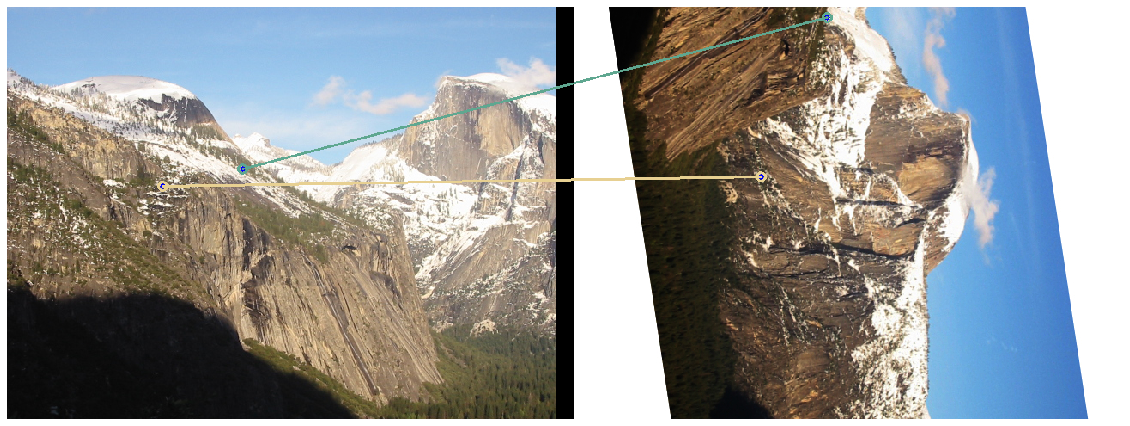

In [79]:
outImg = draw_matches(
    real_img,
    keypoints1,
    real_img_second,
    keypoints2,
    space=20,
    radius=5,
    thickness=2,
    color=None,
)
outImg = outImg[..., ::-1]  # BGR to RGB
imshow(outImg, figsize=(20, 12))

### Adaptive Non Maximum Supression

In [37]:
# def Adaptive_Non_Max_Suppression(corner_response: np.ndarray,
#                                  num_interest_points: int = 100,
#                                  c_robust: float = 0.9):
#     keypoints = np.transpose(np.nonzero(corner_response))

#     radii = []
#     for keypoint in keypoints:
#         min_radius = np.inf
#         for other_keypoint in filter(lambda x: not np.array_equal(x, keypoint),keypoints):
#             if corner_response[keypoint[0], keypoint[1]] < c_robust * corner_response[other_keypoint[0],other_keypoint[1]]:
#                 keypoints, other_keypoints = np.reshape(keypoint, (1, 2)), np.reshape(other_keypoint, (1, 2))
#                 distance = np.linalg.norm(keypoints - other_keypoints)
#                 if distance < min_radius:
#                     min_radius = distance
                    
#         if min_radius != np.inf:
#             radii.append((keypoint, min_radius))
#         radii = sorted(radii, key=itemgetter(1), reverse=True)
#     return np.array([entry[0] for entry in radii])[:num_interest_points]